# NDWI Analysis - Lago de Chapala

This notebook goes step by step inside download_raster_from_pc() in order to be able to __download an image from a specific date__. (Because we verified a specific date using eo Browser)

* Initially the verified date was __2024-09-18__. However, upon realizing it was not available, we decided to use date __2024-09-03__.

## Import libraries

In [8]:
accessibilidad_urbana = "../../"

In [10]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join(accessibilidad_urbana))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:24: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.config(


## Notebook config

In [77]:
# ------------------------------ SCRIPT CONFIGURATION - ANALYSIS ------------------------------
# Set raster spectral bands and analysis equation
band_name_dict = {'green':[False], #If GSD(resolution) of band is different, set True.
                  'nir':[False], #If GSD(resolution) of band is different, set True.
                  'eq':["(green-nir)/(green+nir)"]}
# Set analysis name
index_analysis = 'ndwi'

# Set directory to save analysed rasters
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [8,10]

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2024-09-16'
end_date = '2024-09-19'

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

#Set filter if necessary. Defaults to "{}". 
# Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
#sat_query = {"eo:cloud_cover": {"lt": 10}}
sat_query = {}

# Del rasters after processing.
del_data = False # True

# ------------------------------ SCRIPT CONFIGURATION - AREA OF INTEREST ------------------------------
city = 'Chapala'
mun_gdf = gpd.read_file(accessibilidad_urbana + 'data/external/temporal_todocker/chapala/chapala_polygon.gpkg')
projection_crs = "EPSG:6372"

# ------------------------------ SCRIPT CONFIGURATION - SAVING ------------------------------
raster_to_hex = True #------ Can set False if testing/visualizing downloaded/interpolated rasters. Set True if transfering data to hexs and saving. 
local_save = True #------ Set True if saving locally
save = False #------ Set True if saving to database

EPSG:4326


<Axes: >

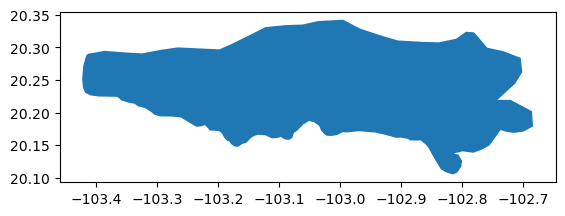

In [22]:
# Show area of interest
print(mun_gdf.crs)
mun_gdf.plot()

## Main function - Create area of interest

In [23]:
# ------------------------------ CREATION OF AREA OF INTEREST ------------------------------
# Create city area of interest with biggest hexs
big_res = min(res)

poly = mun_gdf.to_crs(projection_crs).buffer(500).reset_index()
poly = poly.rename(columns={0:'geometry'})
poly = gpd.GeoDataFrame(poly, geometry='geometry')
poly = poly.to_crs("EPSG:4326")
hex_city = aup.create_hexgrid(poly, big_res)

print(f'Created {len(hex_city)} hexagon features')

#Review result
print(hex_city.shape)
hex_city.head(2)

Created 1436 hexagon features
(1436, 2)


,hex_id_8,geometry
0,8849aa7a57fffff,"POLYGON ((-102.77560 20.23826, -102.77107 20.2..."
1,8849aa7251fffff,"POLYGON ((-102.94168 20.15981, -102.93716 20.1..."


### Main function - Download and proccess rasters

In [24]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, 
#                        tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a",
#                        projection_crs="EPSG:6372", compute_unavailable_dates=True):

df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, 
                                     start_date, end_date, tmp_dir, band_name_dict, 
                                     satellite=satellite, query={"eo:cloud_cover": {"lt": 20}}, projection_crs=projection_crs)

ValueError: Cannot set a DataFrame with multiple columns to the single column year

### Debuging / reviewing function download_raster_from_pc()

In [111]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a",
# projection_crs="EPSG:6372", compute_unavailable_dates=True)
gdf = hex_city.copy()
query = sat_query
compute_unavailable_dates = True

In [78]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs(projection_crs).buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()
# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

Extracting bounding coordinates from hexagons
Defining time of interest


ValueError: Cannot set a DataFrame with multiple columns to the single column year

#### Debugging / reviewing function create_time_of_interest() STARTS

In [72]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [55]:
start_date = '2024-09-16'
end_date = '2024-09-19'

In [56]:
# def create_time_of_interest(start_date, end_date, freq='MS'):
df_tmp_dates = pd.DataFrame() # temporary date dataframe
df_tmp_dates['date'] = pd.date_range(start = start_date,   
                                     end = end_date, 
                                     freq = freq)

df_tmp_dates

,date


In [66]:
start_date = '2024-09-01'
end_date = '2024-09-19'
freq = 'MS'

pd.date_range(start = start_date, end = end_date, freq = freq)

DatetimeIndex(['2024-09-01'], dtype='datetime64[ns]', freq='MS')

In [67]:
start_date = '2024-09-02'
end_date = '2024-09-19'
freq = 'MS'

pd.date_range(start = start_date, end = end_date, freq = freq)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

In [68]:
start_date = '2024-09-02'
end_date = '2024-09-19'
freq = 'D'

pd.date_range(start = start_date, end = end_date, freq = freq)

DatetimeIndex(['2024-09-02', '2024-09-03', '2024-09-04', '2024-09-05',
               '2024-09-06', '2024-09-07', '2024-09-08', '2024-09-09',
               '2024-09-10', '2024-09-11', '2024-09-12', '2024-09-13',
               '2024-09-14', '2024-09-15', '2024-09-16', '2024-09-17',
               '2024-09-18', '2024-09-19'],
              dtype='datetime64[ns]', freq='D')

In [74]:
#####
start_date = '2024-09-16'
end_date = '2024-09-19'
freq = 'D'
#####

df_tmp_dates = pd.DataFrame() # temporary date dataframe
df_tmp_dates['date'] = pd.date_range(start = start_date,   
                            end = end_date, 
                            freq = freq)
# extract month and year from date
df_tmp_dates['month'] = df_tmp_dates.apply(lambda row: row['date'].month, axis=1)
df_tmp_dates['year'] = df_tmp_dates.apply(lambda row: row['date'].year, axis=1)

time_of_interest = []

# create a time range by month
for d in range(len(df_tmp_dates)):
    
    month = df_tmp_dates.loc[df_tmp_dates.index==d].month.values[0]
    year = df_tmp_dates.loc[df_tmp_dates.index==d].year.values[0]

    sample_date = datetime(year, month, 1)
    first_day = sample_date + relativedelta(day=1) # first day of the month
    last_day = sample_date + relativedelta(day=31) # last day of the month

    # append time range to time of interest list with planetary computer format
    time_of_interest.append(f"{year}-{month:02d}-{first_day.day:02d}/{year}"+
                            f"-{month:02d}-{last_day.day:02d}")

time_of_interest

['2024-09-01/2024-09-30',
 '2024-09-01/2024-09-30',
 '2024-09-01/2024-09-30',
 '2024-09-01/2024-09-30']

#### __Specifying time_of_interest directly may solve the problem.__

#### Debugging / reviewing function create_time_of_interest() ENDS

In [125]:
# 2024-09-18 was not available, so using 2024-09-03.
time_of_interest = ['2024-09-02/2024-09-04']
print(query)
print(satellite)

{}
sentinel-2-l2a


In [108]:
# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

print('Checking available tiles for area of interest')
date_list = aup.available_datasets(items, satellite,min_cloud_value=100)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

Gathering items for time and area of interest
Fetched 2 items
Checking available tiles for area of interest
Created dictionary from items


In [115]:
assets_hrefs

{datetime.date(2024, 9, 3): {'green': ['https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/GC/2024/09/03/S2A_MSIL2A_20240903T171901_N0511_R012_T13QGC_20240903T235646.SAFE/GRANULE/L2A_T13QGC_A048057_20240903T173422/IMG_DATA/R10m/T13QGC_20240903T171901_B03_10m.tif?st=2024-09-25T18%3A34%3A32Z&se=2024-09-26T19%3A19%3A32Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-09-26T17%3A36%3A29Z&ske=2024-10-03T17%3A36%3A29Z&sks=b&skv=2024-05-04&sig=sB/wN44%2B5QxyKib/xve1FQmyjwA5MUB8KKglPEMHRlk%3D',
   'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/13/Q/FC/2024/09/03/S2A_MSIL2A_20240903T171901_N0511_R012_T13QFC_20240903T235646.SAFE/GRANULE/L2A_T13QFC_A048057_20240903T173422/IMG_DATA/R10m/T13QFC_20240903T171901_B03_10m.tif?st=2024-09-25T18%3A34%3A32Z&se=2024-09-26T19%3A19%3A32Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2024-09-26T17%

In [126]:
##### MODIFYING start_date AND end_date IN ORDER TO AVOID pd.date_range() PROBLEM INSIDE df_date_links()
start_date = '2024-09-01'
end_date = '2024-09-19'
##### MODIFYING start_date AND end_date IN ORDER TO AVOID pd.date_range() PROBLEM INSIDE df_date_links()

# analyze available data according to raster properties (Creates df_len for the first time)
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
if compute_unavailable_dates:
    aup.available_data_check(df_len, missing_months) # test for missing months

In [123]:
# Raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
print('Created bounding box for raster cropping')

# Create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

Created bounding box for raster cropping


In [124]:
#def create_raster_by_month(df_len, index_analysis, city, tmp_dir, 
#                           band_name_dict, date_list, gdf_raster_test, gdf_bb, 
#                           aoi, sat, query={}, time_exc_limit=1500,
#                           compute_unavailable_dates=True):

# raster creation
print('Starting raster creation for specified time')
# download raster data by month
df_len = aup.create_raster_by_month(df_len, index_analysis, city, tmp_dir,
                                    band_name_dict, date_list, gdf_raster_test, gdf_bb, 
                                    area_of_interest, satellite, query=query)
print('Finished raster creation')

Starting raster creation for specified time


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:47<00:00, 167.18s/it]

Finished raster creation
